In [1]:
import numpyro, numpyro.distributions as dist
import jax, jax.random as random, jax.numpy as jnp, matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth'    : 0.4,
                     'ytick.major.width' : 0.4,
                     'ytick.minor.width' : 0.4,
                     'xtick.major.width' : 0.4,
                     'xtick.minor.width' : 0.4,
                     'xtick.major.size'  : 4,
                     'ytick.major.size'  : 4,
                     'xtick.minor.visible' : 'True',
                     'ytick.minor.visible' : 'True',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize': 8,
                     'axes.labelsize' : 8,
                     'font.family': 'Serif',
                     'figure.figsize': (10/3, 3.3),
                     'figure.dpi' : 200,
                     'ytick.right': 'True',
                     'xtick.top'  : 'True',
                     'ytick.direction': 'in',
                     'xtick.direction': 'in',
                     'axes.spines.top': 'True',
                     'axes.grid': 'False',
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.25
                    })
import seaborn as sns
sns.set_palette('deep')

In [2]:
def inclination_dist(key, shape):
    icdf = lambda u: jnp.arccos(1 - u)
    u = random.uniform(key, shape)
    return icdf(u)

def mean_anomaly_dist(key,shape):
    return 2*jnp.pi*random.uniform(key,shape)

In [3]:
key = random.PRNGKey(11)
shape = (100000,)
i_samples = inclination_dist(key, shape)
M_samples = mean_anomaly_dist(key, shape)
e_samples = random.uniform(key,shape)

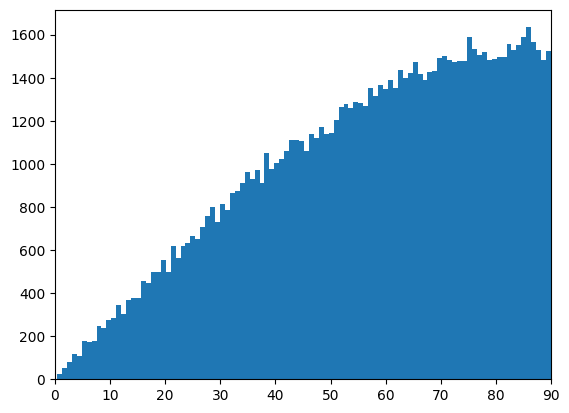

In [169]:
i_samples = i_samples*180/jnp.pi
plt.hist(i_samples, bins=100)
plt.xlim(0,90)
plt.show()

In [21]:
import jaxopt
from functools import partial

In [147]:
def kepler_equation(E, M, e):
    return E - e * jnp.sin(E) - M
def kepler_equation_fixed(E, M, e):
    return M + e * jnp.sin(E)

In [148]:
F = partial(kepler_equation, M=M_samples,e=e_samples)
F_fixed = partial(kepler_equation_fixed, M=M_samples,e=e_samples)

In [149]:
%%time
E = []
for i in range(len(M_samples)):
    E.append(jaxopt.Bisection(partial(kepler_equation, M=M_samples[i],e=e_samples[i]),
                lower=0, upper=2*jnp.pi).run().params)

CPU times: user 26.9 s, sys: 2.66 s, total: 29.6 s
Wall time: 19.6 s


In [150]:
%%time
res = jaxopt.ScipyRootFinding(method='hybr',optimality_fun=F,
                             ).run(init_params=jnp.ones(shape=M_samples.shape)*jnp.pi).params

CPU times: user 393 ms, sys: 27.5 ms, total: 420 ms
Wall time: 395 ms


In [151]:
%%time
res_aa = jaxopt.FixedPointIteration(fixed_point_fun=F_fixed
                                    ).run(init_params=jnp.ones(shape=M_samples.shape)*jnp.pi).params

CPU times: user 55.7 ms, sys: 5.26 ms, total: 60.9 ms
Wall time: 36.9 ms


In [152]:
jnp.abs(kepler_equation(res, M_samples, e_samples)).max()

Array(4.7683716e-07, dtype=float32)

In [153]:
jnp.abs(kepler_equation(jnp.array(E), M_samples, e_samples)).max()

Array(9.953976e-06, dtype=float32)

In [154]:
jnp.abs(kepler_equation(res_aa, M_samples, e_samples)).max()

Array(5.722046e-06, dtype=float32)

In [ ]:
import jax.numpy as jnp
import jax, jax.random as random
from numpyro.distributions import Distribution
from numpyro.distributions.util import validate_sample
import numpyro

class OrbitalInclination(Distribution):
    support = numpyro.distributions.constraints.interval(0, jnp.pi/2)
    
    def __init__(self, validate_args=None):
        super(OrbitalInclination, self).__init__(
            batch_shape=(),
            validate_args=validate_args
        )
    
    def sample(self, key, sample_shape=()):
        """
        Sample from the orbital inclination distribution using inverse CDF sampling.
        
        Args:
            key: PRNGKey for random sampling
            sample_shape: Shape of samples to generate
            
        Returns:
            Samples from orbital inclination distribution in radians
        """
        shape = sample_shape + self.batch_shape
        u = random.uniform(key, shape)
        return jnp.arccos(1 - u)
    
    def log_prob(self, value):
        """
        Compute log probability of the orbital inclination value.
        
        The PDF is p(i) = sin(i) for i in [0, pi/2]
        Therefore log_prob = log(sin(i))
        
        Args:
            value: Value to compute probability for
            
        Returns:
            Log probability of the value
        """
        value = jnp.asarray(value)
        if self._validate_args:
            self._validate_sample(value)
        
        # Handle edge cases where sin(i) = 0
        safe_val = jnp.clip(value, 1e-6, jnp.pi - 1e-6)
        return jnp.log(jnp.sin(safe_val))

    @validate_sample
    def _validate_sample(self, value):
        """
        Validate that samples are in the valid range [0, pi]
        """
        return super()._validate_sample(value)

In [22]:
i = OrbitalInclination().sample(key=random.PRNGKey(42), sample_shape=(1000000,))

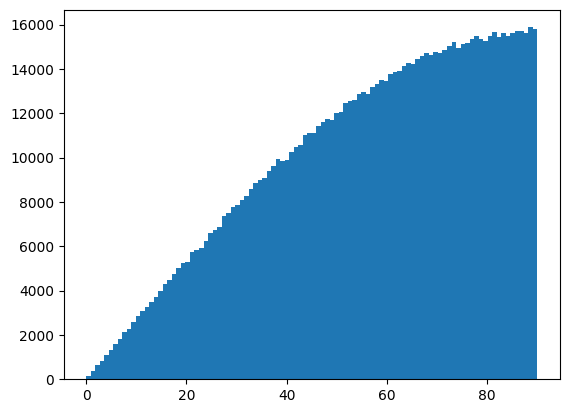

In [24]:
import matplotlib.pyplot as plt
plt.hist(i*180/jnp.pi, bins=100)
plt.show()